TODOS LOS PARTICIPANTES DEL GRUPO HICIMOS LOS EJERCICIOS
TODO EL GRUPO 14

------------------------------------------------------EJERCICIO 1 ------------------------------------------

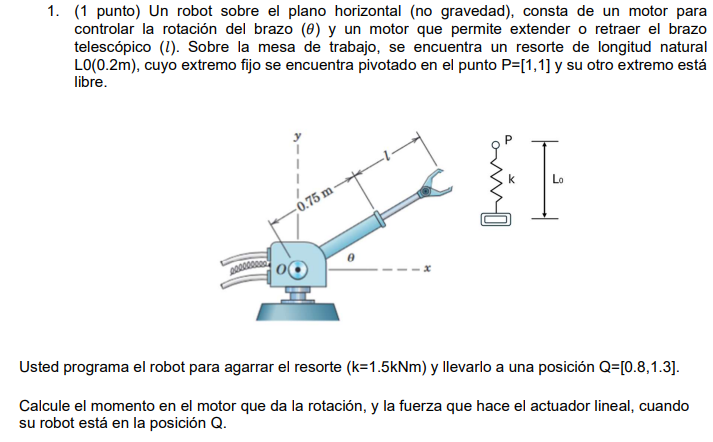

In [1]:

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame

# -------------------------------------------------------------
# 1) Declaración simbólica
# -------------------------------------------------------------
# Variables geométricas y físicas
Qx, Qy, Px, Py = sp.symbols('Qx Qy Px Py', real=True)
k, L0 = sp.symbols('k L0', positive=True)
L_base = sp.symbols('L_base', positive=True)

# -------------------------------------------------------------
# 2) Marcos de referencia
# -------------------------------------------------------------
# Marco inercial (XY)
N = ReferenceFrame('N')

# Vector posición de Q y P en el plano XY
r_Q = Qx * N.x + Qy * N.y
r_P = Px * N.x + Py * N.y

# -------------------------------------------------------------
# 3) Brazo y sus vectores unitarios
# -------------------------------------------------------------
r = sp.sqrt(Qx**2 + Qy**2)
theta = sp.atan2(Qy, Qx)

# Definimos un marco rotado (brazo) R: eje R.x radial, R.y tangencial
R = N.orientnew('R', 'Axis', [theta, N.z])

# Longitud telescópica (desde base hasta Q)
l = r - L_base

# -------------------------------------------------------------
# 4) Fuerza del resorte
# -------------------------------------------------------------
# Vector del resorte y longitud actual
r_QP = r_P - r_Q
L = r_QP.magnitude()
dL = L - L0

# Dirección de la fuerza (de Q hacia P)
u_QP = r_QP.normalize()

# Vector fuerza del resorte en Q (actúa sobre el punto Q)
F_s = k * dL * u_QP

# -------------------------------------------------------------
# 5) Componentes en base del brazo
# -------------------------------------------------------------
F_r = F_s.dot(R.x)   # componente radial
F_t = F_s.dot(R.y)   # componente tangencial

# Par en el motor (en la base): tau = r * F_t (CCW positivo)
tau = r * F_t

# Fuerza del actuador (a lo largo del brazo)
F_act = -F_r  # equilibrio cuasiestático

# -------------------------------------------------------------
# 6) Sustitución numérica (caso del enunciado)
# -------------------------------------------------------------
vals = {
    Px: 1.0,  Py: 1.0,          # P = (1, 1)
    Qx: 0.8,  Qy: 1.3,          # Q = (0.8, 1.3)
    k: 1500.0,                  # 1.5 kN/m
    L0: 0.2,
    L_base: 0.75
}

theta_v = sp.N(theta.subs(vals))
l_v     = sp.N(l.subs(vals))
F_s_v   = F_s.express(N).subs(vals).evalf()
F_r_v   = F_r.subs(vals).evalf()
F_t_v   = F_t.subs(vals).evalf()
tau_v   = tau.subs(vals).evalf()
F_act_v = F_act.subs(vals).evalf()

# -------------------------------------------------------------
# 7) Resultados numéricos
# -------------------------------------------------------------
print("\n=== Valores numéricos ===")
print(f"Tau   = {tau_v:.6f} N·m   # CCW positivo")
print(f"F_act = {F_act_v:.6f} N   # tracción a lo largo de R.x")


=== Valores numéricos ===
Tau   = -333.974853 N·m   # CCW positivo
F_act = 100.645332 N   # tracción a lo largo de R.x


Suponiendo algunos valores de masa e inercia constantes para cada cuerpo, grafique el momento que da la rotación y la fuerza que hace el actuador lineal durante el recorrido del robot, desde la posición inicial de la manija [1,0.8] hasta llevarla al punto Q.


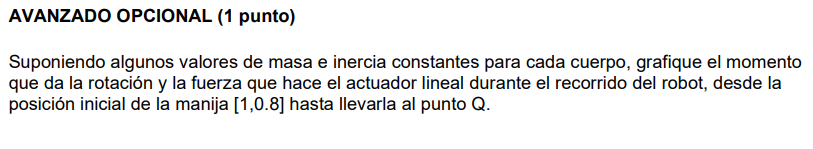

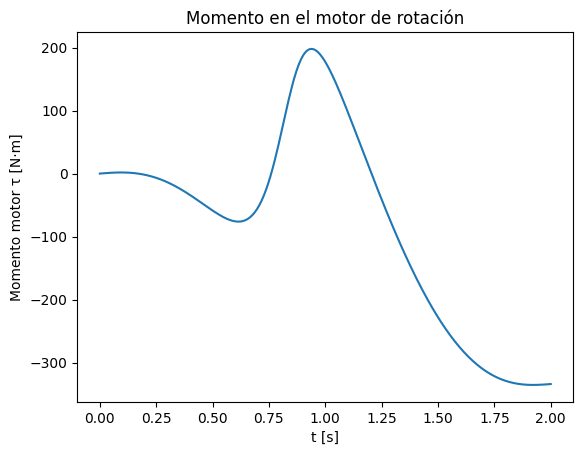

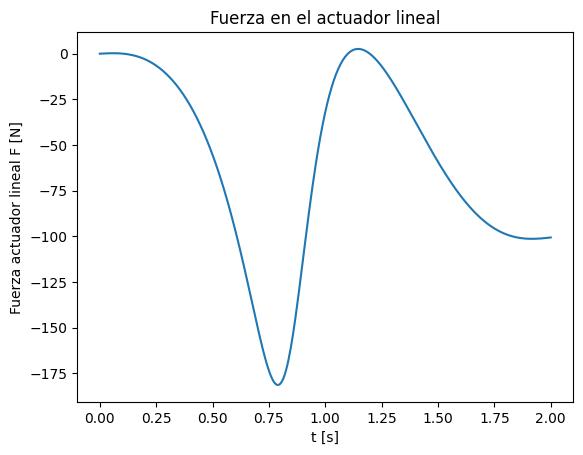

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# ----- 1) Parámetros numéricos (puedes cambiarlos) -----
Px_v, Py_v = 1.0, 1.0           # anclaje del resorte P
k_v, L0_v  = 1500.0, 0.2        # resorte
L_base_v   = 0.75               # tramo fijo del brazo

m_v        = 5.0                # masa efectiva en la garra
Jtheta_v   = 2.0                # inercia equivalente en rotación
m_lin_v    = 1.0                # masa equivalente del actuador lineal

Qi = np.array([1.0, 0.8])       # posición inicial de la manija
Qf = np.array([0.8, 1.3])       # posición final (Q)
T  = 2.0                        # duración de la maniobra (s)
N  = 400                        # número de muestras

# ----- 2) Trayectoria quintica (s, ds, dds) -----
t   = np.linspace(0.0, T, N)
tau = t/T
s   = 10*tau**3 - 15*tau**4 + 6*tau**5
ds  = (30*tau**2 - 60*tau**3 + 30*tau**4)/T
dds = (60*tau - 180*tau**2 + 120*tau**3)/T**2

Q   = Qi[None,:] + s[:,None]*(Qf - Qi)[None,:]
dQ  = ds[:,None]*(Qf - Qi)[None,:]
ddQ = dds[:,None]*(Qf - Qi)[None,:]

x,  y  = Q[:,0],  Q[:,1]
dx, dy = dQ[:,0], dQ[:,1]
ddx, ddy = ddQ[:,0], ddQ[:,1]

# ----- 3) Conversión a polares y derivadas -----
r     = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
dr    = (x*dx + y*dy)/r
dth   = (x*dy - y*dx)/r**2
ddr   = ((dx*dx + x*ddx + dy*dy + y*ddy)*r - (x*dx + y*dy)*dr) / r**2
num   = x*dy - y*dx
dnum  = x*ddy - y*ddx
den   = r**2
ddth  = (dnum*den - num*2*r*dr) / den**2

# ----- 4) Fuerza del resorte en radial/tangencial usando lo SIMBÓLICO -----
# (F_r y F_t ya fueron definidos simbólicamente en el código anterior)
f_Fr = sp.lambdify((Qx, Qy, Px, Py, k, L0), F_r, 'numpy')
f_Ft = sp.lambdify((Qx, Qy, Px, Py, k, L0), F_t, 'numpy')

Fr = f_Fr(x, y, Px_v, Py_v, k_v, L0_v)
Ft = f_Ft(x, y, Px_v, Py_v, k_v, L0_v)

# ----- 5) Esfuerzos generalizados con inercia -----
tau_req = (m_v * r**2 + Jtheta_v) * ddth + 2 * m_v * r * dr * dth + r * Ft
Fact_req = (m_v + m_lin_v) * ddr - m_v * r * dth**2 + Fr

# Extensión del telescopio
l_ext = r - L_base_v

# ----- 6) Gráficas -----
plt.figure()
plt.plot(t, tau_req)
plt.xlabel('t [s]')
plt.ylabel('Momento motor τ [N·m]')
plt.title('Momento en el motor de rotación')

plt.figure()
plt.plot(t, Fact_req)
plt.xlabel('t [s]')
plt.ylabel('Fuerza actuador lineal F [N]')
plt.title('Fuerza en el actuador lineal')

plt.show()

------------------------------------------------------EJERCICIO 2 ------------------------------------------

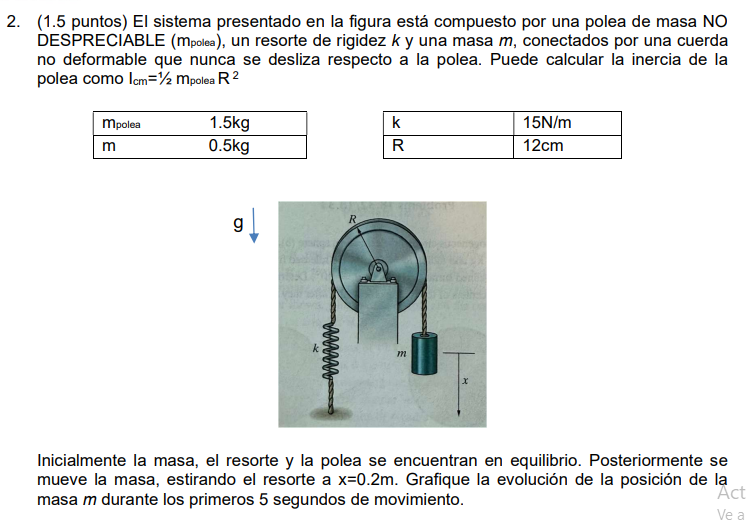

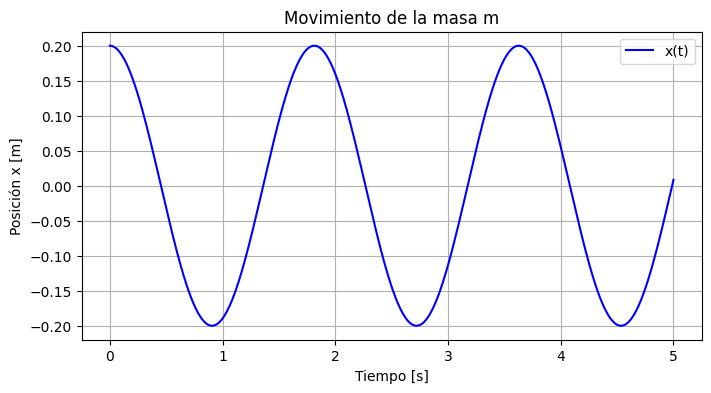

Inercia de la polea I = 0.0108 kg·m²
Masa efectiva m_eq = 1.2500 kg
Frecuencia angular ω = 3.464 rad/s
Período T = 1.814 s


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Datos
m = 0.5         # masa del bloque [kg]
M_polea = 1.5   # masa de la polea [kg]
R = 0.12        # radio [m]
k = 15          # constante del resorte [N/m]
x0 = 0.2        # desplazamiento inicial [m]

I = 0.5 * M_polea * R**2

m_eq = m + I / R**2

omega = np.sqrt(k / m_eq)

t = np.linspace(0, 5, 500)

x = x0 * np.cos(omega * t)

plt.figure(figsize=(8,4))
plt.plot(t, x, 'b', label='x(t)')
plt.title('Movimiento de la masa m')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición x [m]')
plt.grid(True)
plt.legend()
plt.show()

print(f"Inercia de la polea I = {I:.4f} kg·m²")
print(f"Masa efectiva m_eq = {m_eq:.4f} kg")
print(f"Frecuencia angular ω = {omega:.3f} rad/s")
print(f"Período T = {2*np.pi/omega:.3f} s")

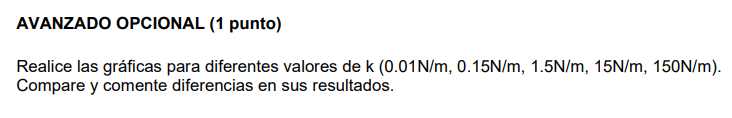

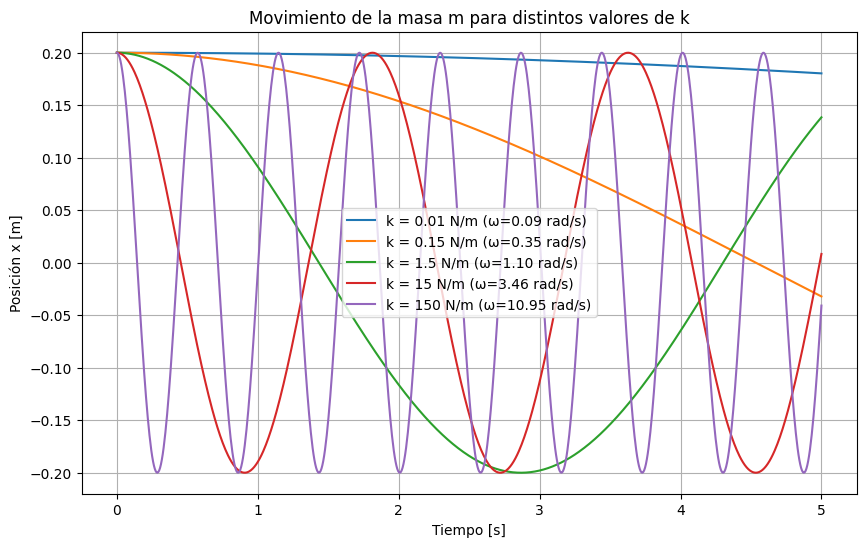

In [5]:
m = 0.5
M_polea = 1.5
R = 0.12
x0 = 0.2
k_values = [0.01, 0.15, 1.5, 15, 150]

I = 0.5 * M_polea * R**2

m_eq = m + I / R**2

t = np.linspace(0, 5, 800)

plt.figure(figsize=(10,6))

for k in k_values:
    omega = np.sqrt(k / m_eq)
    x = x0 * np.cos(omega * t)
    plt.plot(t, x, label=f'k = {k} N/m (ω={omega:.2f} rad/s)')

plt.title('Movimiento de la masa m para distintos valores de k')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición x [m]')
plt.grid(True)
plt.legend()
plt.show()


Comentario: Es interesante obtener todos los armónicos a medida que variamos el k. De forma general, notamos que un mayor K genera una mayor velocidad angular (w) y por tanto un menor periodo. Así, a mayor k, la masa va a demorarse muchísimo más en oscilar. 

------------------------------------------------------EJERCICIO 3 ------------------------------------------

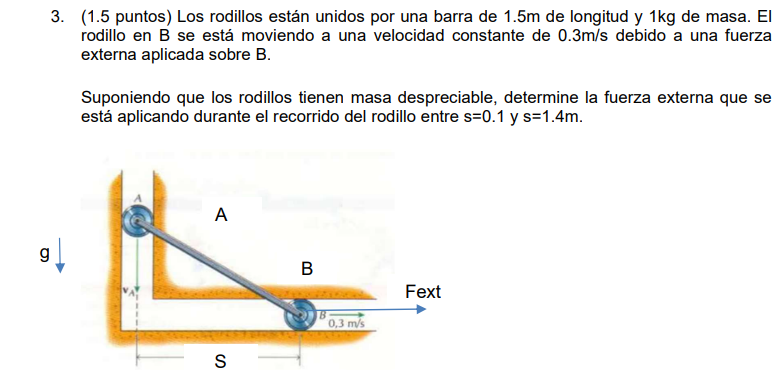

Fuerza externa simbólica F_ext(s):


-g*m*s(t)/(2*sqrt(L**2 - s(t)**2))

Fuerza de reacción normal en A:


g*m*s(t)/(2*sqrt(L**2 - s(t)**2))

Fuerza de reacción normal en B:


g*m

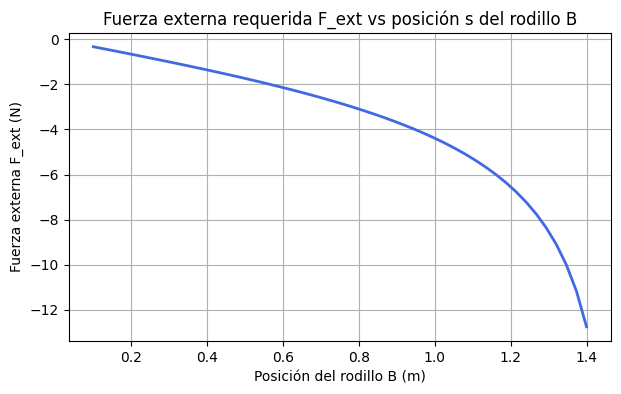

s = 0.10 m → F_ext = -0.328 N
s = 1.40 m → F_ext = -12.752 N


In [6]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols

# =======================
# 1. Definición de variables y marcos
# =======================
N = ReferenceFrame("N")
s = dynamicsymbols("s")        # desplazamiento horizontal del rodillo B
L, m, g = sp.symbols("L m g", positive=True, real=True)

# =======================
# 2. Cinemática geométrica
# =======================
# Relación geométrica: sin(theta) = s / L
theta = sp.asin(s / L)
A = N.orientnew("A", "Axis", (-sp.pi/2 + theta, N.z))  # marco del cuerpo (barra AB)

# Posición del centro de masa desde A (mitad de la barra)
r_G = (L/2) * A.x

# =======================
# 3. Fuerzas aplicadas
# =======================
# Fuerzas desconocidas y externas
N_A, N_B, F_ext = sp.symbols("N_A N_B F_ext")

# Suma de fuerzas (a_CM = 0, movimiento a velocidad constante)
sumF = N_A*N.x + N_B*N.y - m*g*N.y + F_ext*N.x

# =======================
# 4. Momentos respecto al centro de masa
# =======================
r_A = -r_G       # vector desde el CM hacia A
r_B = (L/2)*A.x  # vector desde el CM hacia B

# Momento total en el CM
sumM = r_A.cross(N_A*N.x) + r_B.cross(N_B*N.y) + r_B.cross(F_ext*N.x)

# =======================
# 5. Ecuaciones escalares (Newton-Euler)
# =======================
eqs = [
    sumF.dot(N.x),
    sumF.dot(N.y),
    sumM.dot(N.z)
]

# Resolver sistema simbólico
sol = sp.solve(eqs, [N_A, N_B, F_ext], dict=True)[0]

# Expresión simbólica de la fuerza externa
F_ext_expr = sp.simplify(sol[F_ext])
print("Fuerza externa simbólica F_ext(s):")
display(F_ext_expr)


#Expresión simbólica de las reacciones
print("Fuerza de reacción normal en A:")
N_A_expr = sp.simplify(sol[N_A]) 
display(N_A_expr)
print("Fuerza de reacción normal en B:")
display(sp.simplify(sol[N_B]))

# =======================
# 6. Sustitución de valores numéricos
# =======================
params = {L: 1.5, m: 1, g: 9.81}
s_vals = np.linspace(0.1, 1.4, 50)
F_vals = [float(F_ext_expr.subs(params | {s: val})) for val in s_vals]

# =======================
# 7. Gráfica F_ext vs s
# =======================
plt.figure(figsize=(7,4))
plt.plot(s_vals, F_vals, color='royalblue', linewidth=2)
plt.title("Fuerza externa requerida F_ext vs posición s del rodillo B")
plt.xlabel("Posición del rodillo B (m)")
plt.ylabel("Fuerza externa F_ext (N)")
plt.grid(True)
plt.show()

# =======================
# 8. Valores específicos
# =======================
for val in [0.1, 1.4]:
    print(f"s = {val:.2f} m → F_ext = {float(F_ext_expr.subs(params | {s: val})):0.3f} N")


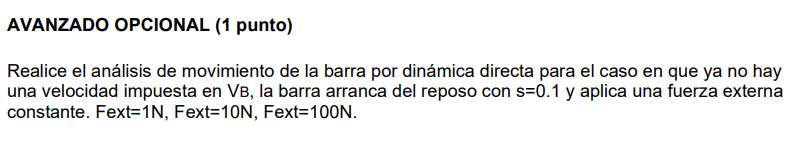

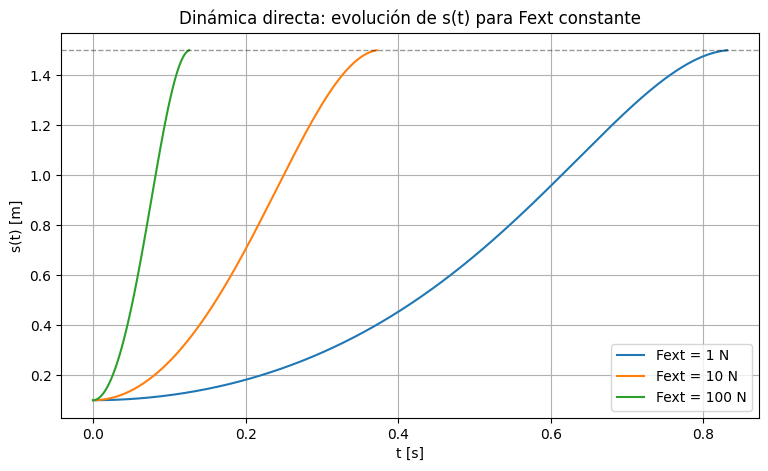

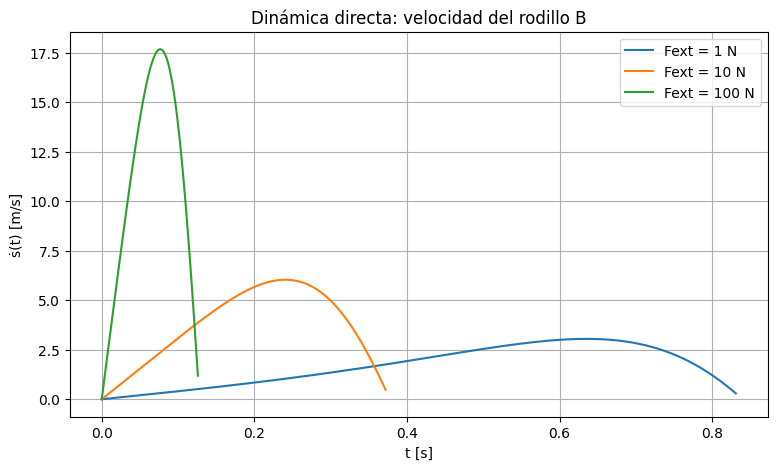

In [7]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) Símbolos y derivación simbólica de la EOM ----------
s = sp.symbols('s', real=True)              # coordenada generalizada
sd, sdd = sp.symbols('sd sdd', real=True)   # velocidad y aceleración (para derivada total)
L, m, g, Fext = sp.symbols('L m g Fext', positive=True)

# Geometría (A en eje vertical, B en eje horizontal):
y  = sp.sqrt(L**2 - s**2)
ys = sp.diff(y, s)                          # dy/ds

# Velocidades del centro de masa (punto medio de la barra)
vGx = sd/2
vGy = (ys*sd)/2

# Velocidad angular de la barra (en z):
omega = (s*(ys*sd) - y*sd) / L**2           # = sd*(s*ys - y)/L^2

# Energía cinética: traslación + rotación (I_G = mL^2/12)
IG = sp.Rational(1, 12)*m*L**2
T = sp.Rational(1,2)*m*(vGx**2 + vGy**2) + sp.Rational(1,2)*IG*omega**2

# Potencial gravitatorio: y_G = y/2 (eje y positivo hacia arriba)
V = m*g*(y/2)

# Lagrangiano
Lagr = T - V

# Ecuación de Lagrange con derivada total: d/dt(∂L/∂sd) - ∂L/∂s = Q
dL_dsd = sp.diff(Lagr, sd)
dL_ds  = sp.diff(Lagr, s)

# d/dt(∂L/∂sd) = (∂/∂s(∂L/∂sd))*sd + (∂/∂sd(∂L/∂sd))*sdd
d_dt_dL_dsd = sp.diff(dL_dsd, s)*sd + sp.diff(dL_dsd, sd)*sdd

# Fuerza generalizada (Fext aplicado en B, r_B = (s,0) => ∂r_B/∂s = (1,0))
Q = Fext

# EOM: d_dt_dL_dsd - dL_ds - Q = 0 -> resolver para sdd
EOM = sp.simplify(d_dt_dL_dsd - dL_ds - Q)
sdd_expr = sp.simplify(sp.solve(sp.Eq(EOM, 0), sdd)[0])

# Función numérica sdd(s, sd, Fext, L, m, g)
f_sdd = sp.lambdify((s, sd, Fext, L, m, g), sdd_expr, 'numpy')

# ---------- 2) Integrador RK4 ----------
def rk4_step(fun, t, y, h):
    # y = [s, sd]
    s_, sd_ = y
    k1 = np.array([sd_, fun(s_, sd_)])
    k2 = np.array([sd_ + 0.5*h*k1[1], fun(s_ + 0.5*h*k1[0], sd_ + 0.5*h*k1[1])])
    k3 = np.array([sd_ + 0.5*h*k2[1], fun(s_ + 0.5*h*k2[0], sd_ + 0.5*h*k2[1])])
    k4 = np.array([sd_ + h*k3[1],     fun(s_ + h*k3[0],     sd_ + h*k3[1])])
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# ---------- 3) Simulación para Fext = 1, 10, 100 N ----------
params = dict(L=1.5, m=1.0, g=9.81)
forces = [1.0, 10.0, 100.0]

t0, tf, h = 0.0, 5.0, 0.001
t = np.arange(t0, tf+h, h)

def make_fun(Fc):
    return lambda s_, sd_: f_sdd(s_, sd_, Fc, params['L'], params['m'], params['g'])

sols = {}

for Fc in forces:
    fun = make_fun(Fc)
    y = np.array([0.1, 0.0])  # s(0)=0.1 m, sdot(0)=0
    S = np.zeros_like(t)
    Sd = np.zeros_like(t)
    S[0], Sd[0] = y
    stop_idx = len(t)-1
    for i in range(len(t)-1):
        # cortar si la geometría deja de ser válida (s -> L)
        if y[0] >= params['L']*0.999: 
            stop_idx = i
            S = S[:i+1]; Sd = Sd[:i+1]; t = t[:i+1]
            break
        y = rk4_step(fun, t[i], y, h)
        S[i+1], Sd[i+1] = y
    sols[Fc] = (t, S, Sd)

# ---------- 4) Gráficas ----------
plt.figure(figsize=(9,5))
for Fc in forces:
    t_, S_, _ = sols[Fc]
    plt.plot(t_, S_, label=f'Fext = {Fc:.0f} N')
plt.axhline(params['L'], ls='--', lw=1, color='k', alpha=0.4)
plt.xlabel('t [s]')
plt.ylabel('s(t) [m]')
plt.title('Dinámica directa: evolución de s(t) para Fext constante')
plt.legend()
plt.grid(True)
plt.show()

# (opcional) también la velocidad
plt.figure(figsize=(9,5))
for Fc in forces:
    t_, _, Sd_ = sols[Fc]
    plt.plot(t_, Sd_, label=f'Fext = {Fc:.0f} N')
plt.xlabel('t [s]')
plt.ylabel('ṡ(t) [m/s]')
plt.title('Dinámica directa: velocidad del rodillo B')
plt.legend()
plt.grid(True)
plt.show()


Comentario: Notamos en la primera gráfica que  al límite de s = 1.5 (la longitud de la barra, la barra en este punto ya se encuentra completamente horizontal) de forma más rápida mientras mayor es la fuerza externa. Además, satisfactoriamente, todas las gráficas llegan a ese punto de 1.5 en algún instante de tiempo. Por otro lado, podemos confirmar la velocidad es mayor mientras más fuerza externa se le aplica, tal como podemos observar en la segunda gráfica. El decaimiento observadoe en las gráficas de velocidad se debe a que a medida que se acerca al valor límite la velocidad disminuye, lo cual es coherente con el hecho que el sistema ya no se puede modelar con una reacción horizontal en A sino una vertical.

------------------------------------------------------EJERCICIO 4 ------------------------------------------

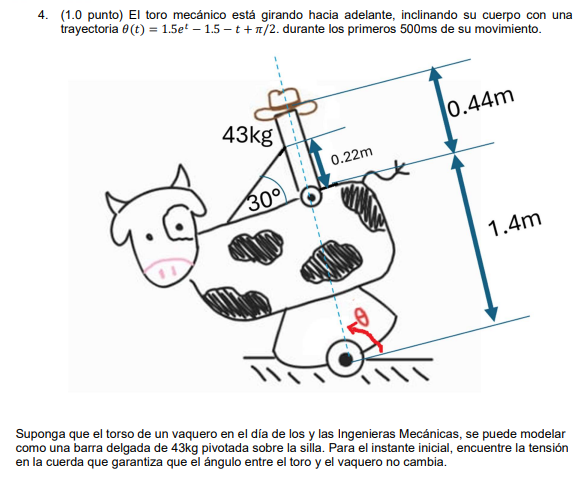

In [8]:
from sympy import symbols, Eq, solve, sin, cos, pi
import sympy as sp
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from scipy.integrate import odeint

# Simbolos
m, g, r, l, t, L = symbols('m, g, r, l, t, L')
theta, gamma, T = dynamicsymbols('theta, gamma, T')

# Algunos Parámetros
alpha = theta.diff(t,t)
theta_func = 1.5*sp.exp(t) - 1.5 - t + pi/2
alpha_func = theta_func.diff(t,t)

gamma = theta - pi/2
# I0 = symbols('I_0')
I0 = (1/12)*m*L**2 + m*r**2

# Ecuación de momentos
SMo = Eq(m*g*r*sin(gamma) + T*r*cos(pi/6), I0*alpha)

# Solución
T = solve(SMo, [T])[0]
Tval = T.subs({L:0.44, r:1.62, m:43, g:9.81, theta:theta_func.subs({t:0}), alpha:alpha_func.subs({t:0})})

print(f'La tensión en la cuerda en el instante inicial es: {round(Tval, 2)} (N)')

# Tensión duante el recorrido
tvals = np.linspace(0, 0.5, 150)
Tvals = []
for i in tvals:
    Tval_i = T.subs({L:0.44, r:1.62, m:43, g:9.81, theta:theta_func.subs({t:i}), alpha:alpha_func.subs({t:i})})
    Tvals.append(Tval_i)

La tensión en la cuerda en el instante inicial es: 121.40 (N)


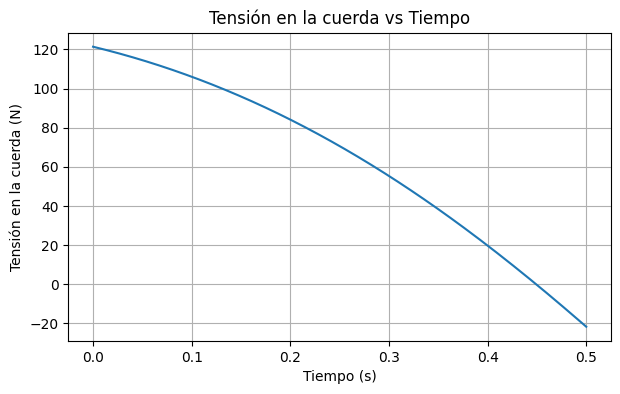

In [9]:
plt.figure(figsize=(7,4))
plt.plot(tvals, Tvals)
plt.title('Tensión en la cuerda vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tensión en la cuerda (N)')
plt.grid()
plt.show()

Observe que, en el intervalo en que está definida la función theta(t), la tensión se vuelve negativa a partir de cierto momento. Sin embargo, esto no tiene sentido dado que una cuerda no puede estar en compresión. Esto quiere decir que, para que la persona se pueda mantener sobre el toro, necesita apoyarse de tal manera en que ejerza una fuerza en dirección contrari a la cuerda. En últimas, el torso no se podría sostener solamente con la tensión en la cuerda. 